In [1]:
#BSCS3AB - BARBIEQ

import cv2
import h5py
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
import tensorflow as tf
import time

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import glorot_uniform
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.layers import Layer
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from sklearn.utils import shuffle
%matplotlib inline


In [2]:
path = "C:/Users/Sophia/Downloads/signatures"
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [3]:
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(os.path.join(path, directory))
    images.sort()
    images = [os.path.join(path, directory, x) for x in images]
    forg_groups.append(images[:30])
    orig_groups.append(images[30:])
    
len(orig_groups), len(forg_groups)

(15, 15)

In [4]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [5]:
print(orig_lengths)
print(forg_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 18, 24, 24, 24]
[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


In [6]:
orig_train, orig_val, orig_test = orig_groups[:10], orig_groups[10:13], orig_groups[13:]
forg_train, forg_val, forg_test = forg_groups[:10], forg_groups[10:13], forg_groups[13:]

del orig_groups, forg_groups

In [7]:
img_h, img_w = 155, 220

def visualize_sample_signature():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

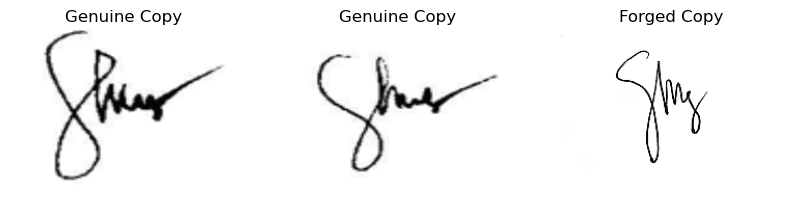

In [8]:
visualize_sample_signature()

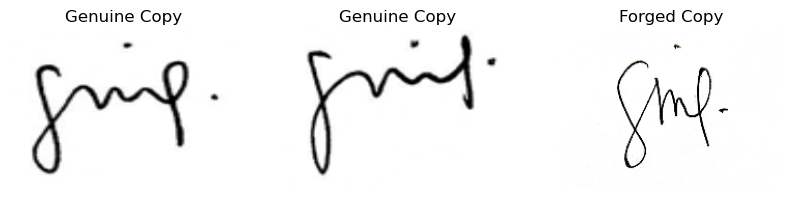

In [9]:
visualize_sample_signature()

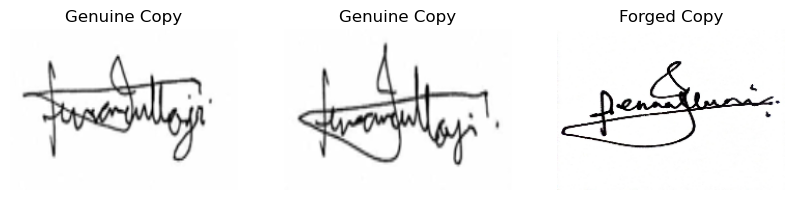

In [10]:
visualize_sample_signature()

In [11]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))

        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))
                
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def create_base_network_signet(input_shape):    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06,axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), data_format='channels_last'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu
    
    return seq

In [12]:
input_shape=(img_h, img_w, 1)

base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

batch_sz = 128
num_train_samples = 276*10 + 300*10
num_val_samples = num_test_samples = 276*3 + 300*3
num_train_samples, num_val_samples, num_test_samples

(5760, 1728, 1728)

In [13]:
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.000001, verbose=1),
    ModelCheckpoint("Model.h5", verbose=1, save_weights_only=False, save_best_only=True, mode='auto',save_freq="epoch")
]

results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 15,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 5.6899 
Epoch 1: val_loss improved from inf to 1.42286, saving model to Model.h5
45/45 [==============================] - 842s 19s/step - loss: 5.6899 - val_loss: 1.4229 - lr: 1.0000e-04
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 1.1643 
Epoch 2: val_loss improved from 1.42286 to 1.37342, saving model to Model.h5
45/45 [==============================] - 751s 17s/step - loss: 1.1643 - val_loss: 1.3734 - lr: 1.0000e-04
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 1.1373 
Epoch 3: val_loss improved from 1.37342 to 1.34208, saving model to Model.h5
45/45 [==============================] - 753s 17s/step - loss: 1.1373 - val_loss: 1.3421 - lr: 1.0000e-04
Epoch 4/15
45/45 [==============================] - ETA: 0s - loss: 1.0452 
Epoch 4: val_loss improved from 1.34208 to 1.22055, saving model to Model.h5
45/45 [==============================] - 760s 17s/step - loss: 1.0452 - va

In [14]:
def compute_accuracy_roc(predictions, labels):
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
    return max_acc, best_thresh

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          6461084     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [15]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])
    
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

1/1 [==============================] - 0s 85ms/step


(0.8547787909490037, 0.2827308303490282)

In [16]:
def predict_score():
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

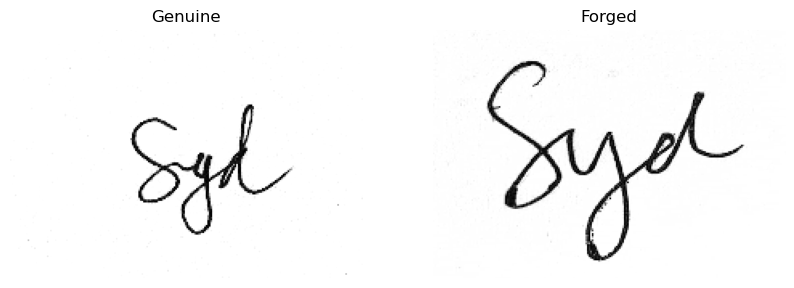

1/1 [==============================] - 0s 81ms/step
Difference Score =  0.43127912
Its a Forged Signature


In [18]:
predict_score()

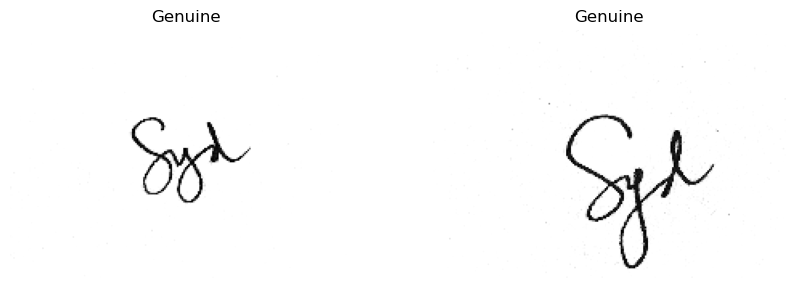

1/1 [==============================] - 0s 80ms/step
Difference Score =  0.19963087
Its a Genuine Signature


In [19]:
predict_score()

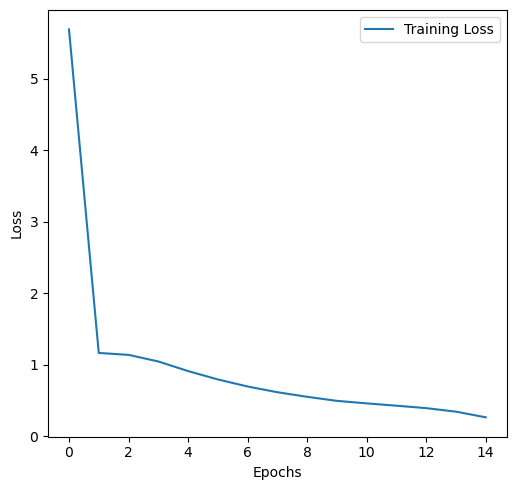

In [20]:
model.save("Model.h5")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
with h5py.File("Model.h5", "r") as file:
    print(file.keys())

<KeysViewHDF5 ['model_weights', 'optimizer_weights']>


In [ ]:
from PIL import Image

def select_images():
    print("Please select two images for testing:")
    image_paths = []
    for i in range(2):
        while True:
            image_path = input(f"Enter the path to image {i+1}: ")
            if os.path.exists(image_path):
                image_paths.append(image_path)
                break
            else:
                print("Invalid image path. Please try again.")
    images = []
    for image_path in image_paths:
        image = Image.open(image_path).convert("L")
        image_resized = image.resize((220, 155))
        image_array = np.array(image_resized)
        image_reshaped = np.expand_dims(image_array, axis=2)
        images.append(image_reshaped)
    
    img1, img2 = images[0], images[1]
    return img1, img2


def predict_score(img1, img2, threshold=0.28):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Image 1')
    ax2.set_title('Image 2')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    
    img1 = np.expand_dims(img1, axis=0)
    img2 = np.expand_dims(img2, axis=0)
    
    result = model.predict([img1, img2])
    diff = result[0][0]
    #threshold = 0.55
    print("Difference Score =", diff)
    if diff > threshold:
        print("It's a Forged Signature")
    else:
        print("It's a Genuine Signature")

selected_img1, selected_img2 = select_images()

predict_score(selected_img1, selected_img2, threshold=0.28)